In [ ]:
cd /content/drive/MyDrive/AAIC course/Case Study 1/Data

/content/drive/MyDrive/AAIC course/Case Study 1/Data


In [ ]:
!pip install plotly --upgrade
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.express as px

from tqdm import tqdm
import datetime as dt
import time
import warnings
from tqdm import tqdm 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from geopy import distance # to find distance between long and lat
import folium # To plot maps

In [ ]:
ls

after_cleaningV1.0.csv            pipeline_temp.pkl
after_cleaningV3.0.csv            product_category_name_translation.csv
feature_engineeringV1.0.feather   sellers_data.csv
merge_one_dfV1.0.csv              sellers_datav1.0.csv
merge_one_dfV1.0.feather          sellers_dataV2.0.feather
modified_seller_age_order.csv     std_scaler_of_train_dataV1.0.bin
olist_customers_dataset.csv       temp.feather
olist_geolocation_dataset.csv     test_df_V1.0.feather
olist_order_items_dataset.csv     train_df_V1.0.feather
olist_order_payments_dataset.csv  train_preprocess_df_V1.0.feather
olist_order_reviews_dataset.csv   X_test.npy
olist_orders_dataset.csv          X_train_res.npy
olist_products_dataset.csv        y_test.npy
olist_sellers_dataset.csv         y_train_res.npy


In [ ]:
# reading train data
df = pd.read_feather('train_preprocess_df_V1.0.feather')
df

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,customer_geolocation_lat,customer_geolocation_lng,distance
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,9350,maua,SP,-23.680729,-46.444238,-23.576983,-46.587161,18.567
1,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04,1,credit_card,2,223.38,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,1,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,11.79,55.0,273.0,1.0,1050.0,38.0,10.0,38.0,bed_bath_table,1,13405,piracicaba,SP,-22.708702,-47.664701,-23.576983,-46.587161,146.371
2,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,1,credit_card,1,44.11,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,2017-09-11 11:43:25,35.39,8.72,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,baby,1,7025,guarulhos,SP,-23.482841,-46.543454,-23.576983,-46.587161,11.341
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,9350,maua,SP,-23.680729,-46.444238,-23.564630,-46.534268,15.803
4,9e9f909cd250058d062bb2b0b0161c92,e15a69da6ddca9fc7bf178c28f529529,2017-07-02 15:37:04,2017-07-04 04:30:13,2017-07-04 10:09:49,2017-07-13 17:36:01,2017-08-01,1,boleto,1,153.69,55fd57195ae0bd2ecf368bbc4be6ad96,3366,sao paulo,SP,1,60c031bf1162848b7ee14f56f432285b,2a5b78b41cd05baeac8df54c6606b92c,2017-07-10 04:30:13,137.97,15.72,55.0,706.0,2.0,225.0,18.0,11.0,13.0,health_beauty,1,35570,formiga,MG,-20.462536,-45.433059,-23.564630,-46.534268,361.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80229,3fc88ecf6531f387f4888fe47105b4a4,083e2b1ff42c5edf19de624a88fe80ec,2017-11-29 21:03:45,2017-11-29 21:17:21,2017-11-30 16:33:44,2018-01-13 01:55:34,2018-01-04,1,credit_card,4,294.19,6e31fbbf8fab8292ce3539ade13d31a4,59213,japi,RN,1,a75b732b129c2fe3d8e371dd8333cd00,78a4d36f65a019172c6154468831a69f,2017-12-05 21:17:21,229.90,64.29,38.0,731.0,5.0,6400.0,16.0,2.0,11.0,kitchen_dining_laundry_garden_furniture,0,17018,bauru,SP,-22.359934,-49.051325,-6.466574,-35.946180,2252.554
80230,1fa3133aa187f5523ca99748f5b5578f,6eb2a1fc81674d4d2877d51a498375e1,2017-06-01 19:08:30,2017-06-01 19:22:56,2017-06-06 15:35:09,2017-06-07 07:32:52,2017-06-14,1,credit_card,1,98.04,19637bd7c7c8c0b7023d9f668928e761,2110,sao paulo,SP,1,1b97621fc0e6ac58cfb272d5ccf8c15b,dc8798cbf453b7e0f98745e396cc5616,2017-06-07 19:22:56,24.90,4.67,55.0,1241.0,2.0,1000.0,16.0,2.0,11.0,fashion_male_clothing,1,5455,sao paulo,SP,-23.541383,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80234 entries, 0 to 80233
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       80234 non-null  object        
 1   customer_id                    80234 non-null  object        
 2   order_purchase_timestamp       80234 non-null  datetime64[ns]
 3   order_approved_at              80234 non-null  datetime64[ns]
 4   order_delivered_carrier_date   80234 non-null  datetime64[ns]
 5   order_delivered_customer_date  80234 non-null  datetime64[ns]
 6   order_estimated_delivery_date  80234 non-null  datetime64[ns]
 7   payment_sequential             80234 non-null  int64         
 8   payment_type                   80234 non-null  object        
 9   payment_installments           80234 non-null  int64         
 10  payment_value                  80234 non-null  float64       
 11  customer_unique

In [ ]:
# checking the percentile of feature
def percentile_col(data):
    print('checking the percentile of feature')
    for i in range(0,100,10):
        var = np.sort(data,axis = None)
        print("{} percentile value is {}".format(i,np.round(np.percentile(var,i),2)))
    for i in range(90,100,1):
        print("{} percentile value is {}".format(i,np.round(np.percentile(var,i),2)))
    for i in np.arange(0.0, 1.0, 0.1):
        print("{} percentile value is {}".format(99+i,np.round(np.percentile(var,99+i),2)))
    print("100 percentile value is ",var[-1])

In [ ]:
# to find out inter quantile range and outliers
def IQR(x, dev):
    # dev is deviation from IQR
    print('IQR, lower, upper range')
    x = sorted(x)
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    out0 = q25 - (dev*iqr)
    out1 = q75 + (dev*iqr)
    return iqr, out0, out1

# 4.0 Feature Engineering

In [ ]:
# taking hour from timestamp
df['purchase_time'] = df.order_purchase_timestamp.dt.hour
# taking month from timestamp
df['purchase_month'] = df.order_purchase_timestamp.dt.month
# taking week and weedays from timestamp
df['purchase_weekday'] = df.order_purchase_timestamp.dt.weekday
df['purchase_week'] = df.order_purchase_timestamp.dt.week

# to find delivery is late or not
# estimate - deliver date
df['difference_in_delivery'] = (df.order_estimated_delivery_date - df.order_delivered_customer_date).dt.days
# convert into hours
# df['difference_in_delivery'] = df.difference_in_delivery.astype('timedelta64[h]')
# Is it late
def is_late(x):
    if x >= 0:
        # Early
        return 1
    else:
        # late
        return 0
df['late'] = 0
df.late = df.difference_in_delivery.apply(lambda x: is_late(x))
# order to freight ratio
# add 1 to avoid divide with 0
df['order_fre_ratio'] = df.price / (df.freight_value+1)

# estimate days in delivery
df['estimate_day'] = (df.order_estimated_delivery_date - df.order_purchase_timestamp).dt.days

# actual day to delivery
df['actual_delivery'] = (df.order_delivered_customer_date - df.order_purchase_timestamp).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [ ]:
percentile_col(df.order_fre_ratio)

checking the percentile of feature
0 percentile value is 0.04
10 percentile value is 1.47
20 percentile value is 2.1
30 percentile value is 2.72
40 percentile value is 3.32
50 percentile value is 4.03
60 percentile value is 4.91
70 percentile value is 5.97
80 percentile value is 7.63
90 percentile value is 10.72
90 percentile value is 10.72
91 percentile value is 11.23
92 percentile value is 11.83
93 percentile value is 12.58
94 percentile value is 13.38
95 percentile value is 14.49
96 percentile value is 15.98
97 percentile value is 17.87
98 percentile value is 20.65
99 percentile value is 26.65
99.0 percentile value is 26.65
99.1 percentile value is 27.87
99.2 percentile value is 29.0
99.3 percentile value is 29.92
99.4 percentile value is 31.82
99.5 percentile value is 35.41
99.6 percentile value is 53.9
99.7 percentile value is 69.9
99.8 percentile value is 99.9
99.9 percentile value is 110.0
100 percentile value is  219.0


In [ ]:
print('If we take 99.5 percentile of data then we only loose {0}% of data.'.\
      format(np.round(100 * len(df[df.order_fre_ratio >= 35.41]) / len(df), 2)))

If we take 99.5 percentile of data then we only loose 0.5% of data.


In [ ]:
# taking values less than 35
df = df[df.order_fre_ratio <= 35]

In [ ]:
percentile_col(df.difference_in_delivery)

checking the percentile of feature
0 percentile value is -189.0
10 percentile value is 1.0
20 percentile value is 5.0
30 percentile value is 7.0
40 percentile value is 9.0
50 percentile value is 11.0
60 percentile value is 13.0
70 percentile value is 15.0
80 percentile value is 17.0
90 percentile value is 21.0
90 percentile value is 21.0
91 percentile value is 21.0
92 percentile value is 22.0
93 percentile value is 23.0
94 percentile value is 24.0
95 percentile value is 25.0
96 percentile value is 26.0
97 percentile value is 28.0
98 percentile value is 30.0
99 percentile value is 34.0
99.0 percentile value is 34.0
99.1 percentile value is 35.0
99.2 percentile value is 35.0
99.3 percentile value is 37.0
99.4 percentile value is 38.0
99.5 percentile value is 39.0
99.6 percentile value is 41.0
99.7 percentile value is 42.0
99.8 percentile value is 45.0
99.9 percentile value is 49.0
100 percentile value is  146


In [ ]:
print('If we take 99.9 percentile of data then we only loose {0}% of data.'.\
      format(np.round(100 * len(df[df.difference_in_delivery > 49]) / len(df), 2)))

If we take 99.9 percentile of data then we only loose 0.09% of data.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


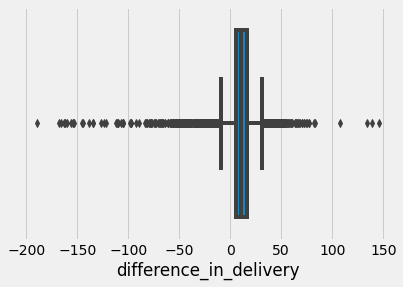

In [ ]:
sns.boxplot(df.difference_in_delivery)

In [ ]:
print('If we take remove outliers of data then we only loose {0}% of data.'.\
      format(np.round(100 * len(df[df.difference_in_delivery < -100]) / len(df), 2)))

If we take remove outliers of data then we only loose 0.04% of data.


In [ ]:
# taking values less than 49 and greater than -100
df = df[df.difference_in_delivery < 49]
df = df[df.difference_in_delivery > -100]

In [ ]:
# reseting index
df.reset_index(drop=True,inplace=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# one hot encoding of columns payment_type
coun_vect_pay = CountVectorizer(lowercase=False)
count_matrix = coun_vect_pay.fit_transform(df.payment_type)
# Converting sparse matrix to array of array
count_array = count_matrix.toarray()
# array to dataframe
one_hot_pay = pd.DataFrame(data=count_array,columns = coun_vect_pay.get_feature_names())
# Join the encoded df
df = df.join(one_hot_pay)
# Drop column payment_type because it is encoded
df = df.drop('payment_type', axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# to use vocab while deploying
coun_vect_pay.vocabulary_

{'boleto': 0, 'credit_card': 1, 'debit_card': 2, 'voucher': 3}

In [ ]:
# Checking weitage of category
100 * df.product_category_name_english.value_counts()[:20]/len(df)

bed_bath_table              9.819099
health_beauty               9.149187
sports_leisure              8.026395
computers_accessories       7.168306
furniture_decor             6.403051
housewares                  6.182256
watches_gifts               5.423274
telephony                   4.547621
toys                        3.968035
auto                        3.955490
garden_tools                3.585407
cool_stuff                  3.575371
perfumery                   3.379667
baby                        2.830189
electronics                 2.757427
stationery                  2.507778
fashion_bags_accessories    2.017262
pet_shop                    1.757577
consoles_games              1.086411
office_furniture            0.993577
Name: product_category_name_english, dtype: float64

In [ ]:
# we taking only those category who particiapation is in top 20
# take other categories as other
prod_eng_ind = ['bed_bath_table', 'health_beauty', 'sports_leisure',
       'computers_accessories', 'furniture_decor', 'housewares',
       'watches_gifts', 'telephony', 'auto', 'toys', 'garden_tools',
       'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
       'fashion_bags_accessories', 'pet_shop', 'consoles_games',
       'office_furniture']

# function to seperate top 20 and others
def cat_val(valu):
    if valu in set(prod_eng_ind):
        return valu
    else:
        return 'other'

In [ ]:
# create new column and map other
df['cat_english'] = df['product_category_name_english']
df['cat_english'] = df['cat_english'].apply(lambda x:cat_val(x))

In [ ]:
# new distribution
100*df['cat_english'].value_counts()/len(df)

other                       10.866620
bed_bath_table               9.819099
health_beauty                9.149187
sports_leisure               8.026395
computers_accessories        7.168306
furniture_decor              6.403051
housewares                   6.182256
watches_gifts                5.423274
telephony                    4.547621
toys                         3.968035
auto                         3.955490
garden_tools                 3.585407
cool_stuff                   3.575371
perfumery                    3.379667
baby                         2.830189
electronics                  2.757427
stationery                   2.507778
fashion_bags_accessories     2.017262
pet_shop                     1.757577
consoles_games               1.086411
office_furniture             0.993577
Name: cat_english, dtype: float64

In [ ]:
# one hot encoding of columns category name
coun_vect_cat = CountVectorizer(lowercase=False)
count_matrix = coun_vect_cat.fit_transform(df.cat_english)
# Converting sparse matrix to array of array
count_array = count_matrix.toarray()
# array to dataframe
one_hot_cat = pd.DataFrame(data=count_array,columns = coun_vect_cat.get_feature_names())
# Join the encoded df
df = df.join(one_hot_cat)
# Drop column category name because it is encoded
df = df.drop(['product_category_name_english','cat_english'], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# to use vocab while deploying
coun_vect_cat.vocabulary_

{'auto': 0,
 'baby': 1,
 'bed_bath_table': 2,
 'computers_accessories': 3,
 'consoles_games': 4,
 'cool_stuff': 5,
 'electronics': 6,
 'fashion_bags_accessories': 7,
 'furniture_decor': 8,
 'garden_tools': 9,
 'health_beauty': 10,
 'housewares': 11,
 'office_furniture': 12,
 'other': 13,
 'perfumery': 14,
 'pet_shop': 15,
 'sports_leisure': 16,
 'stationery': 17,
 'telephony': 18,
 'toys': 19,
 'watches_gifts': 20}

# 4.2 RFM -Analysis

**What is RFM?**

Behavioral segmentation by 3 important features:

* Recency: How recently has the customer made a transaction with us

* Frequency: How frequent is the customer in ordering/buying some product from us

* Monetary: How much does the customer spend on purchasing products from us.

More details - https://www.geeksforgeeks.org/rfm-analysis-analysis-using-python/

While doing EDA we observe that only 11% customer are repeated customers if we find out RFM which is customer lifetime value so it just a act like outliers because very few customers are repeated 

But because of Olist is a marketplace hence seller is also important and good the good the rating so we are performing RFM on seller

rfm score is : 0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score

In [ ]:
# Recency — number of days since the last purchase
# by grouping on seller id we find out last order date for each seller
df_recency = df.groupby(by='seller_id', as_index=False)['order_purchase_timestamp'].max()
# renaming the columns of dataframe
df_recency.columns = ['seller_id', 'latestorder']
# getting latest date to find out who recently get order
recent_date = df.order_purchase_timestamp.max()
# finding the number of days between recent date and last order get to the seller
df_recency['recency'] = df_recency['latestorder'].apply(lambda x:(recent_date - x).days)
# showing the data
df_recency.head()

,seller_id,latestorder,recency
0,001cca7ae9ae17fb1caed9dfb1094831,2018-07-12 21:38:26,47
1,002100f778ceb8431b7a1020ff7ab48f,2018-04-12 12:58:23,139
2,004c9cd9d87a3c30c522c48c4fc07416,2018-05-01 18:06:57,119
3,00720abe85ba0859807595bbf045a33b,2018-08-03 16:57:01,25
4,00ab3eff1b5192e5f1a63bcecfee11c8,2017-03-18 11:40:26,529


In [ ]:
# Frequency — number of transactions made over a given period
# number of orders get to the seller
df_frequency = df.groupby(by='seller_id', as_index=False)['order_purchase_timestamp'].count()
# renaming the columns
df_frequency.columns = ['seller_id', 'frequency']
df_frequency.head()

,seller_id,frequency
0,001cca7ae9ae17fb1caed9dfb1094831,158
1,002100f778ceb8431b7a1020ff7ab48f,48
2,004c9cd9d87a3c30c522c48c4fc07416,116
3,00720abe85ba0859807595bbf045a33b,12
4,00ab3eff1b5192e5f1a63bcecfee11c8,1


In [ ]:
# Monetary — amount spent over a given period of time
# amount of sale done by each seller
df_monetary = df.groupby(by='seller_id', as_index=False)['price'].sum()
# rename columns
df_monetary.columns = ['seller_id', 'monetary']
df_monetary.head()

,seller_id,monetary
0,001cca7ae9ae17fb1caed9dfb1094831,16477.36
1,002100f778ceb8431b7a1020ff7ab48f,1115.20
2,004c9cd9d87a3c30c522c48c4fc07416,12690.92
3,00720abe85ba0859807595bbf045a33b,677.40
4,00ab3eff1b5192e5f1a63bcecfee11c8,98.00


In [ ]:
# merging three dataframe
df_rmf = df_frequency.merge(df_recency, on='seller_id')
df_rmf = df_rmf.merge(df_monetary, on='seller_id').drop(columns='latestorder')
df_rmf.head()

,seller_id,frequency,recency,monetary
0,001cca7ae9ae17fb1caed9dfb1094831,158,47,16477.36
1,002100f778ceb8431b7a1020ff7ab48f,48,139,1115.20
2,004c9cd9d87a3c30c522c48c4fc07416,116,119,12690.92
3,00720abe85ba0859807595bbf045a33b,12,25,677.40
4,00ab3eff1b5192e5f1a63bcecfee11c8,1,529,98.00


In [ ]:
# normalizing the rank of the sellers to get the ranking
# getting rank
# less recency is good so decending
df_rmf['R_rank'] = df_rmf['recency'].rank(ascending=False)
# more frequency is good so ascending
df_rmf['F_rank'] = df_rmf['frequency'].rank(ascending=True)
# more buy is obviously good also ascending
df_rmf['M_rank'] = df_rmf['monetary'].rank(ascending=True)

# normalizing the rank of the customers
df_rmf['R_rank_norm'] = (df_rmf['R_rank']/df_rmf['R_rank'].max())*100
df_rmf['F_rank_norm'] = (df_rmf['F_rank']/df_rmf['F_rank'].max())*100
df_rmf['M_rank_norm'] = (df_rmf['F_rank']/df_rmf['M_rank'].max())*100
# droping rank columns
df_rmf.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
# showing data
df_rmf.head()

,seller_id,frequency,recency,monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,001cca7ae9ae17fb1caed9dfb1094831,158,47,16477.36,49.083427,96.682818,96.682818
1,002100f778ceb8431b7a1020ff7ab48f,48,139,1115.20,30.882903,86.489005,86.489005
2,004c9cd9d87a3c30c522c48c4fc07416,116,119,12690.92,34.511785,94.763325,94.763325
3,00720abe85ba0859807595bbf045a33b,12,25,677.40,61.129817,65.616847,65.616847
4,00ab3eff1b5192e5f1a63bcecfee11c8,1,529,98.00,3.815937,9.504286,9.504286


In [ ]:
# calculate RMF score using formula
# 0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score
df_rmf['RFM_Score'] = 0.15*df_rmf['R_rank_norm']+0.28 * df_rmf['F_rank_norm']+0.57*df_rmf['M_rank_norm']
# to get the score between 1 to 10
df_rmf['RFM_Score'] *= 0.1
# round up value upto 2 decimal points
df_rmf['RFM_Score'] = np.round(df_rmf['RFM_Score'],2)
df_rmf

,seller_id,frequency,recency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,001cca7ae9ae17fb1caed9dfb1094831,158,47,16477.36,49.083427,96.682818,96.682818,8.95
1,002100f778ceb8431b7a1020ff7ab48f,48,139,1115.20,30.882903,86.489005,86.489005,7.81
2,004c9cd9d87a3c30c522c48c4fc07416,116,119,12690.92,34.511785,94.763325,94.763325,8.57
3,00720abe85ba0859807595bbf045a33b,12,25,677.40,61.129817,65.616847,65.616847,6.49
4,00ab3eff1b5192e5f1a63bcecfee11c8,1,529,98.00,3.815937,9.504286,9.504286,0.87
...,...,...,...,...,...,...,...,...
2678,ffc470761de7d0232558ba5e786e57b7,26,11,1296.82,79.087168,78.438315,78.438315,7.85
2679,ffdd9f82b9a447f6f8d4b91554cc7dd3,13,10,1005.70,80.621025,67.163623,67.163623,6.92
2680,ffeee66ac5d5a62fe688b9d26f83f534,11,107,1449.89,36.849981,63.883712,63.883712,5.98
2681,fffd5413c0700ac820c7069d66d98c89,38,2,4179.30,97.268986,83.730898,83.730898,8.58


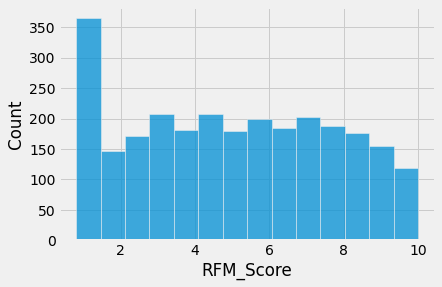

In [ ]:
# create bins
sns.histplot(df_rmf.RFM_Score)

* We can rate the sellers like 

rfm score >8.5 : Top Seller

8.5 > rfm score > 8 : High Value Seller

4>rfm score >6 : Medium value Seller

6>rfm score>2.2 : Low-value Seller

rfm score<1.5 : New Seller

In [ ]:
# here we select the first order of seller id
# from 1st order day we find out the seller age 
# means number of days he active on Olist selling platform
seller_age = pd.DataFrame(df.groupby('seller_id').min()['order_purchase_timestamp'])
# Latest order - first order of customer
seller_age['age'] = (max(df.order_purchase_timestamp) - seller_age['order_purchase_timestamp']).dt.days
# remove date column
seller_age.drop(columns=['order_purchase_timestamp'], inplace=True)
# showing data
seller_age.head()

,age
seller_id,
001cca7ae9ae17fb1caed9dfb1094831,570
002100f778ceb8431b7a1020ff7ab48f,349
004c9cd9d87a3c30c522c48c4fc07416,579
00720abe85ba0859807595bbf045a33b,214
00ab3eff1b5192e5f1a63bcecfee11c8,529


* We are not using review score feature to create average rating for individual seller, because that create data leakage

In [ ]:
# join age of seller with rfm df so we have all features of seller in one dataframe
df_rmf = df_rmf.merge(seller_age, on='seller_id')

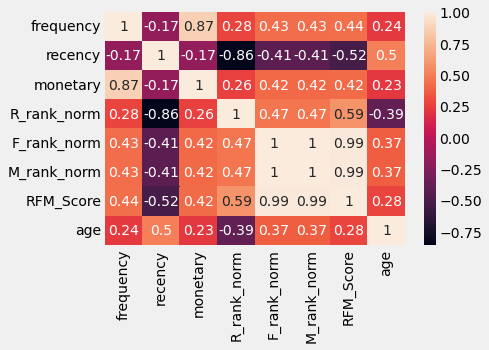

In [ ]:
sns.heatmap(df_rmf.corr(), annot=True)

* M_rank, F_rank are highely correlated with each other
* Also highly correlated with RFM_score 

In [ ]:
df_rmf.drop(columns=['F_rank_norm','R_rank_norm','M_rank_norm'], inplace=True)

In [ ]:
# saving sellers data
df_rmf.to_feather('sellers_dataV2.0.feather')

In [ ]:
df = df.merge(df_rmf, on='seller_id')
df.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,customer_geolocation_lat,customer_geolocation_lng,distance,purchase_time,purchase_month,purchase_weekday,purchase_week,difference_in_delivery,late,order_fre_ratio,estimate_day,actual_delivery,boleto,credit_card,debit_card,voucher,auto,baby,bed_bath_table,computers_accessories,consoles_games,cool_stuff,electronics,fashion_bags_accessories,furniture_decor,garden_tools,health_beauty,housewares,office_furniture,other,perfumery,pet_shop,sports_leisure,stationery,telephony,toys,watches_gifts,frequency,recency,monetary,RFM_Score,age
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,1,9350,maua,SP,-23.680729,-46.444238,-23.576983,-46.587161,18.567,10,10,0,40,7,1,3.085391,15,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,50,296,2220.15,7.62,420
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,1,9350,maua,SP,-23.680729,-46.444238,-23.564630,-46.534268,15.803,18,8,1,33,9,1,3.415718,12,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,50,296,2220.15,7.62,420
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,1,9350,maua,SP,-23.680729,-46.444238,-23.600462,-46.655318,23.300,18,8,2,31,7,1,3.415718,12,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,50,296,2220.15,7.62,420
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,1,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,40.0,268.0,4.0,500.0,19.0,8.0,13.0,0,9350,maua,SP,-23.680729,-46.444238,-27.528367,-48.491914,473.254,23,10,0,43,5,1,1.986093,20,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,50,296,2220.15,7.62,420
4,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14,1,1,127.45,7a1de9bde89aedca8c5fbad489c5571c,1315,sao paulo,SP,2,be03d93320192443b8fa24c0ca6ead98,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-30 11:45:25,46.80,67.70,59.0,189.0,3.0,775.0,16.0,16.0,13.0,0,9350,maua,SP,-23.680729,-46.444238,-23.554090,-46.640389,24.442,11,8,3,34,16,1,0.681223,20,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,50,296,2220.15,7.62,420


In [ ]:
df.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'review_score', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'seller_geolocation_lat', 'seller_geolocation_lng',
       'customer_geolocation_lat', 'customer_geolocation_lng', 'distance',
       'purchase_time', 'purchase_month', 'purchase_weekday', 'purchase_week',
       'difference_in_delivery', 'late', 'order_fre_ratio', 'estimate_da

In [ ]:
# removing unwanted columns
df.drop(columns=['order_id', 'customer_id', 'order_purchase_timestamp','order_approved_at', \
                 'order_delivered_carrier_date','order_delivered_customer_date', \
                 'order_estimated_delivery_date','customer_unique_id', 'customer_zip_code_prefix', \
                 'customer_city','customer_state', 'order_item_id', 'product_id', 'seller_id',\
                 'shipping_limit_date', 'seller_zip_code_prefix', 'seller_city', 'seller_state',\
                 'seller_geolocation_lat', 'seller_geolocation_lng','customer_geolocation_lat', \
                 'customer_geolocation_lng'],inplace=True)

In [ ]:
df.shape

(79712, 53)

In [ ]:
df.corr()['review_score']

payment_sequential           -0.002254
payment_installments         -0.019116
payment_value                -0.038952
price                         0.007173
freight_value                -0.027550
product_name_lenght          -0.013926
product_description_lenght    0.017085
product_photos_qty            0.010561
product_weight_g             -0.014707
product_length_cm            -0.009385
product_height_cm            -0.005396
product_width_cm             -0.008232
review_score                  1.000000
distance                     -0.048189
purchase_time                 0.002504
purchase_month                0.031016
purchase_weekday             -0.009510
purchase_week                 0.030984
difference_in_delivery        0.245352
late                          0.319985
order_fre_ratio               0.017353
estimate_day                 -0.043966
actual_delivery              -0.304422
boleto                       -0.004575
credit_card                   0.005596
debit_card               

In [ ]:
df.to_feather('feature_engineeringV1.0.feather')

# 5.0 Baseline Models

## 5.1 Prepare for models

In [ ]:
cd /content/drive/MyDrive/AAIC course/Case Study 1/Data

/content/drive/MyDrive/AAIC course/Case Study 1/Data


In [ ]:
!pip install plotly --upgrade
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.express as px

from tqdm import tqdm
import datetime as dt
import time
import warnings
from tqdm import tqdm 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from geopy import distance # to find distance between long and lat
import folium # To plot maps

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# read the feature engineer data
df = pd.read_feather('feature_engineeringV1.0.feather')

In [ ]:
# columns that we dont require standardization
not_std_col = ['late', 'boleto', 'credit_card', 'debit_card', 'voucher','auto', 'baby', \
            'bed_bath_table', 'computers_accessories','consoles_games', 'cool_stuff', \
            'electronics','fashion_bags_accessories', 'furniture_decor', 'garden_tools',\
            'health_beauty', 'housewares', 'office_furniture', 'other', 'perfumery','pet_shop', \
            'sports_leisure', 'stationery', 'telephony', 'toys','watches_gifts','payment_sequential',\
            'payment_installments', 'purchase_month', 'purchase_weekday', 'purchase_week','RFM_Score','review_score']

In [ ]:
# get the columns we need to standardize
std_col = df.loc[:,~df.columns.isin(not_std_col)].columns
std_col

Index(['payment_value', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'distance', 'purchase_time', 'difference_in_delivery',
       'order_fre_ratio', 'estimate_day', 'actual_delivery', 'frequency',
       'recency', 'monetary', 'age'],
      dtype='object')

In [ ]:
# features and target variable seperate
X = df.drop('review_score',axis=1)
y = df.review_score

In [ ]:
X.shape

(79708, 52)

In [ ]:
# standardize the data
from sklearn.preprocessing import StandardScaler
# std_scale = StandardScaler()
# X.loc[:,std_col] = std_scale.fit_transform(X.loc[:,std_col])

In [ ]:
# save standard scaler for deployment
import joblib
# joblib.dump(std_scale, 'std_scaler.bin', compress=True)

In [ ]:
# load save standarized files from disk
import joblib
std_scale = joblib.load('std_scaler.bin')
X.loc[:,std_col] = std_scale.transform(X.loc[:,std_col])

In [ ]:
# split data with stratify to y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Matthews Correlation Coefficient (MCC) Metrics
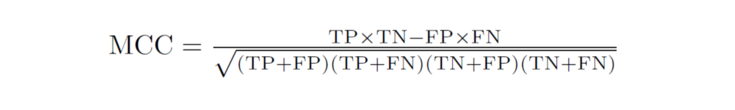

* MCC takes into account all four values in the confusion matrix, and a high value (close to 1) means that both classes are predicted well, even if one class is disproportionately under- (or over-) represented.

[source](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a)

In [ ]:
def performace_of_model(model, y_train, X_train, y_test,X_test):
    # to check the performance of model
    # predict using model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # printing matthew coef for train and test
    print('Matthews coef on Train data is ',matthews_corrcoef(y_train, y_train_pred))
    print('Matthews coef on Test data is ',matthews_corrcoef(y_test,y_test_pred))

    # printing classification report
    target_names = ['class 0', 'class 1']
    print('Classification report for train data is : \n')
    print(classification_report(y_train, y_train_pred, target_names=target_names))

    print('Classification report for test data is : \n')
    print(classification_report(y_test,y_test_pred, target_names=target_names))

    # creating confusion matrix
    cf_train = confusion_matrix(y_train,y_train_pred)
    cf_test = confusion_matrix(y_test,y_test_pred)

    # heatmap of confusion matrix on train data
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sns.heatmap(cf_train/np.sum(cf_train), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Train Confusion matrix")

    # heatmap of confusion matrix on test data
    plt.subplot(1,2,2)
    sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt=".2%", cmap='YlGnBu')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Test Confusion matrix")
    plt.show()


## 5.2 Models

Matthews coef on Train data is  0.3297691114555496
Matthews coef on Test data is  0.3360022018724151
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.69      0.24      0.35     11024
     class 1       0.83      0.97      0.90     42380

    accuracy                           0.82     53404
   macro avg       0.76      0.60      0.62     53404
weighted avg       0.80      0.82      0.78     53404

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.70      0.24      0.36      5430
     class 1       0.83      0.97      0.90     20874

    accuracy                           0.82     26304
   macro avg       0.77      0.61      0.63     26304
weighted avg       0.80      0.82      0.78     26304



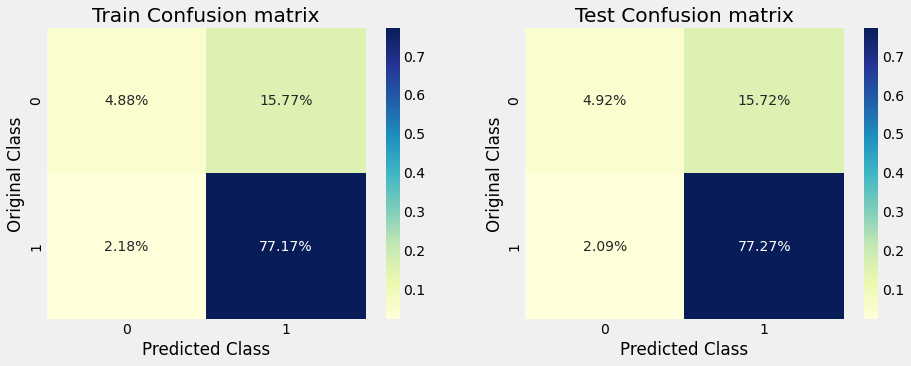

In [ ]:
# Logistic regression
lr_clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
performace_of_model(lr_clf, y_train, X_train, y_test, X_test)

Matthews coef on Train data is  0.2839958887411136
Matthews coef on Test data is  0.28010044713373616
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       0.50      0.32      0.39     11024
     class 1       0.84      0.92      0.88     42380

    accuracy                           0.79     53404
   macro avg       0.67      0.62      0.63     53404
weighted avg       0.77      0.79      0.78     53404

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.50      0.31      0.38      5430
     class 1       0.84      0.92      0.88     20874

    accuracy                           0.79     26304
   macro avg       0.67      0.62      0.63     26304
weighted avg       0.77      0.79      0.77     26304



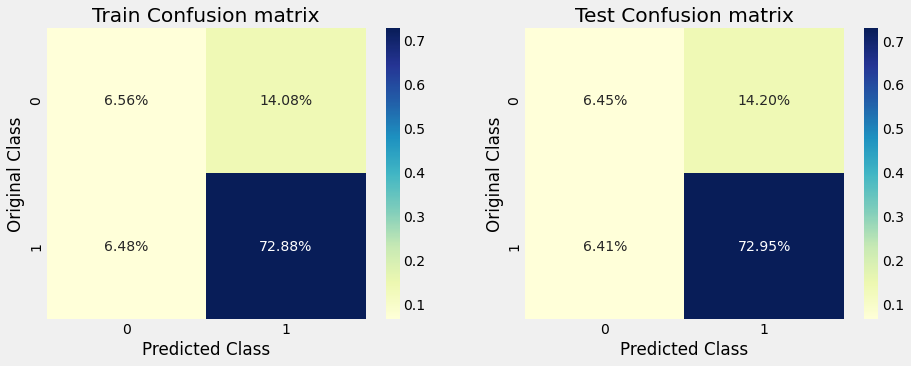

In [ ]:
# Navie Bayes
GNB = GaussianNB().fit(X_train, y_train)
performace_of_model(GNB, y_train, X_train, y_test, X_test)

Matthews coef on Train data is  1.0
Matthews coef on Test data is  0.16276403421927715
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     11024
     class 1       1.00      1.00      1.00     42380

    accuracy                           1.00     53404
   macro avg       1.00      1.00      1.00     53404
weighted avg       1.00      1.00      1.00     53404

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.33      0.36      0.34      5430
     class 1       0.83      0.81      0.82     20874

    accuracy                           0.72     26304
   macro avg       0.58      0.58      0.58     26304
weighted avg       0.73      0.72      0.72     26304



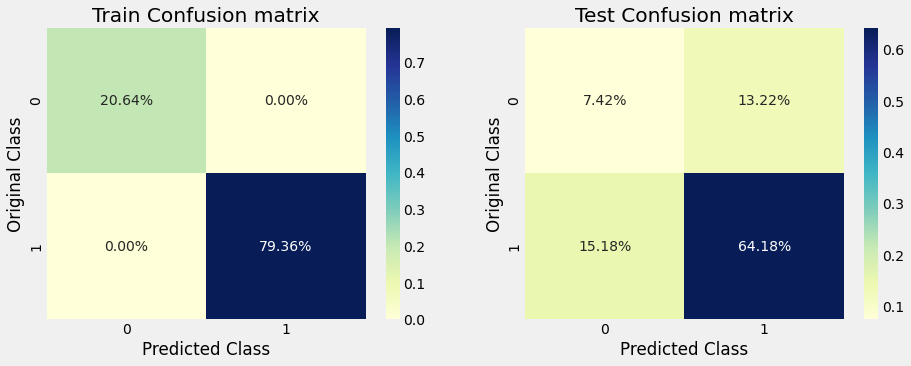

In [ ]:
# Decision Tree
dt_clf = DecisionTreeClassifier().fit(X_train, y_train)
performace_of_model(dt_clf, y_train, X_train, y_test, X_test)

* Decision tree overfit on data (Matthews coef = 1 which is perfect score)
* But on test dataset it not perform well (Matthews coef = 0.16 which is very much far away from 1)

**(1 is perfect Matthews coef score)

Matthews coef on Train data is  0.9998856916494573
Matthews coef on Test data is  0.34502850288443576
Classification report for train data is : 

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     11024
     class 1       1.00      1.00      1.00     42380

    accuracy                           1.00     53404
   macro avg       1.00      1.00      1.00     53404
weighted avg       1.00      1.00      1.00     53404

Classification report for test data is : 

              precision    recall  f1-score   support

     class 0       0.74      0.23      0.35      5430
     class 1       0.83      0.98      0.90     20874

    accuracy                           0.82     26304
   macro avg       0.79      0.60      0.62     26304
weighted avg       0.81      0.82      0.79     26304



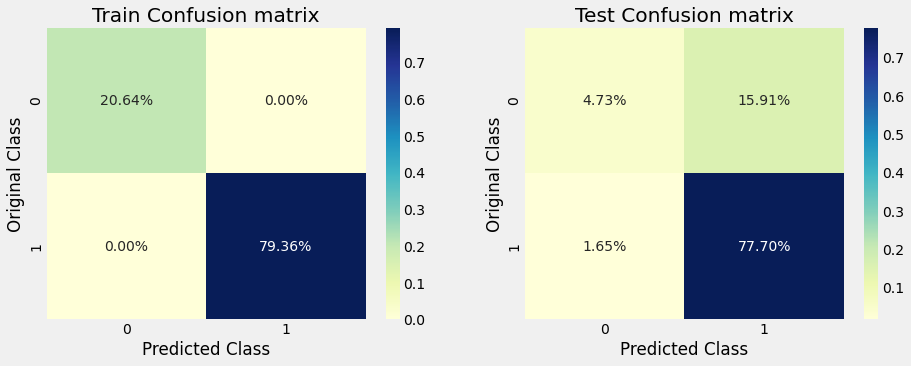

In [ ]:
# Random Forest
rfcl = RandomForestClassifier().fit(X_train, y_train)
performace_of_model(rfcl, y_train, X_train, y_test, X_test)

Insight:
* Tree model are overfitting
* means on test data not perform well
* When we see classification report on test dataset we observe F1 score of class 0 is too low, but for class 1 is good.
* From that we can conclude that because of imbalance class this can happen
